In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

In [12]:
# Función para gráficar histogramas de variables numéricas (hecho con ayuda de deepseek r1)
def plot_numeric_analysis(df, numeric_cols, figsize=(15, 10)):
    """Gráfica histogramas de variables numéricas, adaptando los ejes a la data."""
    if not numeric_cols:
        print("No hay columnas numéricas para graficar.")
        return

    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    if len(numeric_cols) <= 2:
        figsize = (8, 5)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Análisis de Variables Numéricas', fontsize=16)

    # Aplanar los ejes para simplificar la iteración
    axes = np.array(axes).flatten() if isinstance(axes, np.ndarray) else np.array([axes])

    for idx, col in enumerate(numeric_cols):
        # Se extrae la data de la columna ignorando valores nulos
        data = df[col].dropna()
        # Se calcula un margen del 5% del rango para que el gráfico no esté muy pegado a los bordes
        if not data.empty:
            margin = 0.05 * (data.max() - data.min())
            x_min = data.min() - margin
            x_max = data.max() + margin
        else:
            x_min, x_max = 0, 1

        # Graficamos el histograma usando bins automáticos para mejor adaptación
        sns.histplot(data=df, x=col, ax=axes[idx], bins='auto')
        axes[idx].set_title(f'Distribución de {col}')
        axes[idx].set_xlim(x_min, x_max)

    # Ocultar subplots no utilizados
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)

    # Ajustamos el layout dejando espacio para el título general
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Función para detectar outlayers con el método IQR, extremos y no extremos
def iqr_method(column):
    """Detecta outliers usando el método IQR."""
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    extreme_lower_bound = q1 - 3 * iqr
    extreme_upper_bound = q3 + 3 * iqr
    return pd.Series([column>upper_bound, column<lower_bound, column>extreme_upper_bound, column<extreme_lower_bound], 
                     index=['outliers_upper', 'outliers_lower', 'extreme_upper', 'extreme_lower'])

# Función para realizar un análisis exploratorio de una tabla (mejorado con ayuda de claude 3.7 sonnet)
def analisis_exploratorio(name, df):
    """Realiza un análisis exploratorio de una tabla."""
    total_chars = 125
    print("="*total_chars)
    string = f"Análisis de la tabla {name}"
    print('|' + string.center(total_chars-2) + '|')
    print("="*total_chars)
    print(f"Dimensiones: {df.shape}")
    
    # Expresión regular para identificar columnas ID
    id_pattern = re.compile(
        r'^id_.*|.*_id$|^id$',  # Empieza con id_, termina con _id, o es exactamente id
        flags=re.IGNORECASE
    )
    id_cols = [col for col in df.columns if id_pattern.fullmatch(col)]
    
    # Separar columnas numéricas y no numéricas
    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in id_cols]
    non_numeric_cols = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
    
    # Normalizar strings y manejar IDs
    for col in non_numeric_cols:
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].apply(lambda x: x.lower().strip() if pd.notna(x) else x)
    
    # Agregar IDs a no numéricas para estadísticas especiales
    non_numeric_cols += id_cols

    non_numeric_stats = []
    if non_numeric_cols:
        for col in non_numeric_cols:
            stats = {
                'Columna': col,
                'Valores Únicos': df[col].nunique(),
                'Media': '-',
                'Desviación Estándar': '-',
                'Mínimo': df[col].min() if col in id_cols else '-',
                'Mediana': '-',
                'Máximo': df[col].max() if col in id_cols else '-'
            }
            non_numeric_stats.append(stats)
    
    numeric_stats = []
    cols_to_remove = []
    if numeric_cols:
        for col in numeric_cols:
            if df[col].nunique() == 2 and set(df[col].dropna().unique()).issubset({0, 1}):
                df[col] = df[col].astype('boolean')
                cols_to_remove.append(col)
            else:
                numeric_stats.append({
                    'Columna': col,
                    'Valores Únicos': df[col].nunique(),
                    'Media': df[col].mean(),
                    'Desviación Estándar': df[col].std(),
                    'Mínimo': df[col].min(),
                    'Mediana': df[col].median(),
                    'Máximo': df[col].max()
                })
        # Remover columnas convertidas a boolean
        numeric_cols = [col for col in numeric_cols if col not in cols_to_remove]
    
    # Crear un único DataFrame con todas las estadísticas
    all_stats = []
    
    for col in df.columns:
        is_numeric = col in numeric_cols
        
        stats = {
            'Columna': col,
            'Valores Únicos': df[col].nunique(),
            'Media': df[col].mean() if is_numeric else '-',
            'Desviación Estándar': df[col].std() if is_numeric else '-',
            'Mínimo': df[col].min() if is_numeric or col in id_cols else '-',
            'Mediana': df[col].median() if is_numeric else '-',
            'Máximo': df[col].max() if is_numeric or col in id_cols else '-',
            'Tipos de datos': df[col].apply(type).unique() if len(df[col].apply(type).unique()) == 1 else '\n'.join(str(t) for t in df[col].apply(type).unique()),
            'NaN/Null': df[col].isnull().sum(),
            'Duplicados únicos': len(df[(df.duplicated(subset=[col], keep='first'))&(df[col].notnull())]),
            'Duplicados totales': len(df[(df.duplicated(subset=[col], keep=False))&(df[col].notnull())])
        }
        
        # Agregar información de outliers solo para columnas numéricas
        if is_numeric:
            iqr_stats = iqr_method(df[col])
            stats.update({
                'Outlayers (IQR extreme_lower)': iqr_stats['extreme_lower'].sum(),
                'Outlayers (IQR lower)': iqr_stats['outliers_lower'].sum(),
                'Outlayers (IQR upper)': iqr_stats['outliers_upper'].sum(),
                'Outlayers (IQR extreme_upper)': iqr_stats['extreme_upper'].sum()
            })
        else:
            stats.update({
                'Outlayers (IQR extreme_lower)': '-',
                'Outlayers (IQR lower)': '-',
                'Outlayers (IQR upper)': '-',
                'Outlayers (IQR extreme_upper)': '-'
            })
            
        all_stats.append(stats)
    
    # Crear un único DataFrame con todas las estadísticas
    all_stats_df = pd.DataFrame(all_stats).set_index('Columna')
    inconsistencias_stats_df = all_stats_df.T
    
    print('\nEstadísticas descriptivas y problemas de calidad:')
    print(inconsistencias_stats_df.to_markdown(index=True))
    
    if numeric_cols:
        plot_numeric_analysis(df, numeric_cols)
    return


|                                                 Análisis de la tabla Calls                                                |
Dimensiones: (137735, 4)

Estadísticas descriptivas y problemas de calidad:
|                               | id              | user_id         | call_date       | duration          |
|:------------------------------|:----------------|:----------------|:----------------|:------------------|
| Valores Únicos                | 137735          | 481             | 351             | 2802              |
| Media                         | -               | -               | -               | 6.745927033796782 |
| Desviación Estándar           | -               | -               | -               | 5.839241137578812 |
| Mínimo                        | 1000_145        | 1000            | -               | 0.0               |
| Mediana                       | -               | -               | -               | 5.98              |
| Máximo                        | 1499_99 

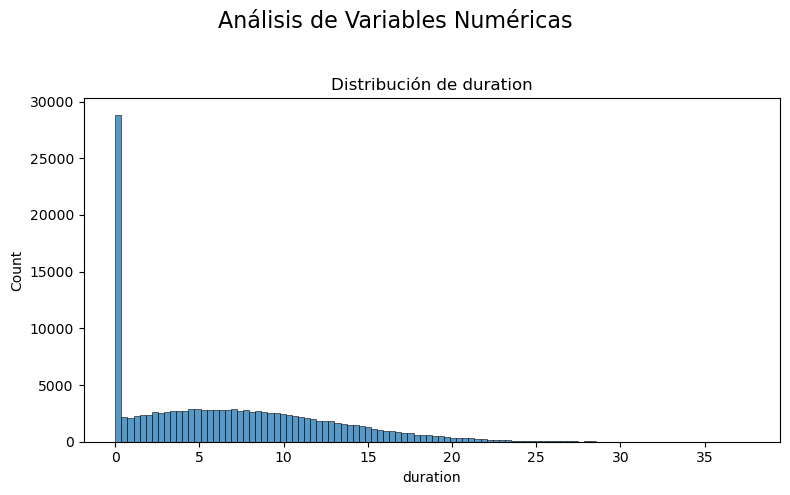

In [43]:
source_file = '../data/raw/megaline_calls.csv'
df_calls = pd.read_csv(source_file, low_memory=False)
analisis_exploratorio('Calls', df_calls)

Esta tabla no presenta muchas incosistencias, lo que podría ser relevante serían los outlayers en duration. Ya que hay cerca de 30000 registros con duración 0 y 508 registros siendo outlayers superiores.

In [50]:
outliers_duration = iqr_method(df_calls['duration'])
df_calls[outliers_duration['outliers_upper']]

,id,user_id,call_date,duration
26,1001_19,1001,2018-11-15,30.00
98,1001_163,1001,2018-12-04,26.88
142,1001_244,1001,2018-12-16,26.85
317,1002_211,1002,2018-12-12,26.22
444,1003_54,1003,2018-12-21,25.50
...,...,...,...,...
135910,1493_72,1493,2018-09-08,25.95
135970,1493_132,1493,2018-10-08,25.84
136042,1493_204,1493,2018-10-10,25.95
136183,1494_25,1494,2018-08-09,27.53


Los outlayers parecen normales entonces no hay nada que hacerles

In [14]:
df_calls[df_calls['duration'] == 0]

,id,user_id,call_date,duration
19,1001_4,1001,2018-12-05,0.0
25,1001_13,1001,2018-12-24,0.0
31,1001_30,1001,2018-10-17,0.0
32,1001_31,1001,2018-11-03,0.0
34,1001_35,1001,2018-12-21,0.0
...,...,...,...,...
137714,1499_183,1499,2018-11-10,0.0
137715,1499_184,1499,2018-09-15,0.0
137720,1499_189,1499,2018-12-27,0.0
137722,1499_191,1499,2018-12-24,0.0


In [15]:
df_calls[df_calls['duration'] == 0].groupby('user_id')['duration'].count()

user_id
1001    59
1002    19
1003    31
1004    64
1005     9
        ..
1495    45
1496    37
1497    12
1498    80
1499    33
Name: duration, Length: 478, dtype: int64

<Axes: title={'center': 'Cantidad de llamadas con duración 0 por usuario'}, xlabel='user_id'>

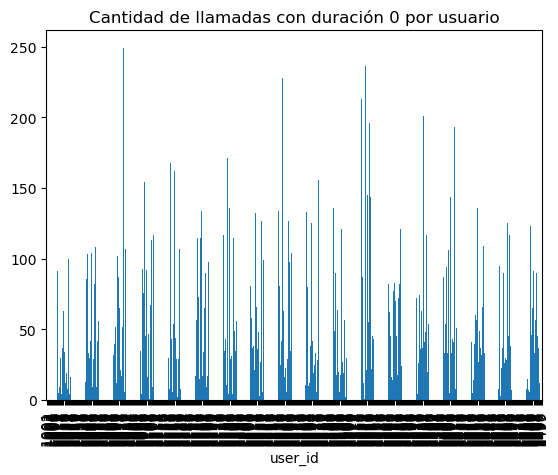

In [16]:
df_calls[df_calls['duration'] == 0].groupby('user_id')['duration'].count().plot(kind='bar', title='Cantidad de llamadas con duración 0 por usuario')

|                                               Análisis de la tabla Internet                                               |
Dimensiones: (104825, 4)

Estadísticas descriptivas y problemas de calidad:
|                               | id              | user_id         | session_date    | mb_used            |
|:------------------------------|:----------------|:----------------|:----------------|:-------------------|
| Valores Únicos                | 104825          | 489             | 351             | 57624              |
| Media                         | -               | -               | -               | 366.71370102551873 |
| Desviación Estándar           | -               | -               | -               | 277.1705420373537  |
| Mínimo                        | 1000_13         | 1000            | -               | 0.0                |
| Mediana                       | -               | -               | -               | 343.98             |
| Máximo                        | 1

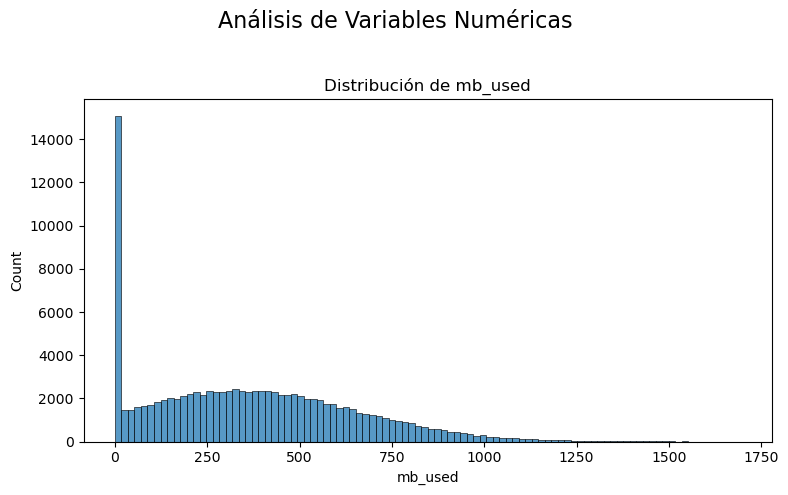

In [17]:
source_file = '../data/raw/megaline_internet.csv'
df_internet = pd.read_csv(source_file, low_memory=False)
analisis_exploratorio('Internet', df_internet)

Aqui de igual forma no hay incosistencias importantes a excepción de mb_used que tiene varios registros con 0 y 424 registros como outlayers superiores

In [51]:
outliers_duration = iqr_method(df_internet['mb_used'])
df_internet[outliers_duration['outliers_upper']]

,id,user_id,session_date,mb_used
400,1003_26,1003,2018-12-24,1222.45
414,1003_40,1003,2018-12-23,1220.86
950,1006_17,1006,2018-12-06,1301.96
972,1006_132,1006,2018-12-12,1257.78
1172,1007_156,1007,2018-12-16,1282.83
...,...,...,...,...
103064,1493_182,1493,2018-09-07,1249.18
103222,1494_104,1494,2018-09-25,1223.24
103929,1497_171,1497,2018-12-24,1221.44
104695,1499_90,1499,2018-12-22,1444.97


Los outlayers parecen normales entonces no hay nada que hacerles

In [21]:
df_internet[df_internet['mb_used'] == 0]

,id,user_id,session_date,mb_used
1,1000_204,1000,2018-12-31,0.0
14,1001_26,1001,2018-09-17,0.0
16,1001_28,1001,2018-10-17,0.0
34,1001_54,1001,2018-09-02,0.0
43,1001_77,1001,2018-10-31,0.0
...,...,...,...,...
104797,1499_192,1499,2018-09-19,0.0
104804,1499_199,1499,2018-12-09,0.0
104816,1499_211,1499,2018-09-26,0.0
104817,1499_212,1499,2018-09-11,0.0


In [22]:
df_internet[df_internet['mb_used'] == 0].groupby('user_id')['mb_used'].count()

user_id
1000     1
1001    35
1002    28
1003     1
1004    62
        ..
1495    45
1496    52
1497     4
1498    98
1499    34
Name: mb_used, Length: 477, dtype: int64

<Axes: title={'center': 'Cantidad de sesiones de internet con 0 MB usados por usuario'}, xlabel='user_id'>

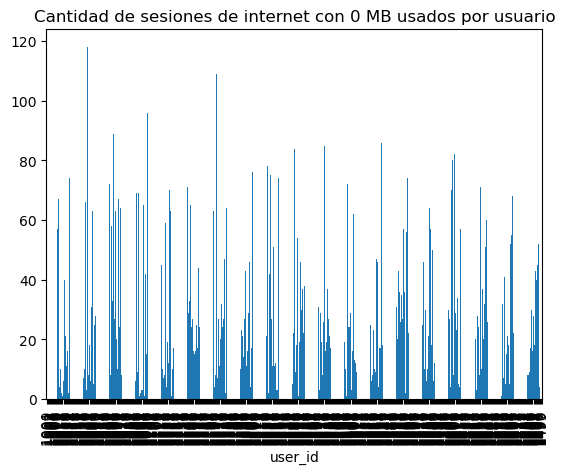

In [24]:
df_internet[df_internet['mb_used'] == 0].groupby('user_id')['mb_used'].count().plot(kind='bar', title='Cantidad de sesiones de internet con 0 MB usados por usuario')

In [47]:
df = df_calls.join(df_internet, on='user_id', how='outer', lsuffix='_calls', rsuffix='_internet')
df[(df['mb_used'] == 0) & (df['duration'] == 0)].groupby('user_id')['duration'].count()

user_id
1007     73
1029     70
1041     86
1062     67
1063      6
1069     52
1071    102
1078      6
1103     47
1110     88
1113     89
1141    144
1168      7
1186      4
1197     38
1200     13
1203    132
1207      7
1213     21
1296     20
1299    121
1301     19
1302     57
1304     30
1309     12
1313    103
1318     32
1321     87
1327     55
1330     22
1335     75
1346     82
1354     70
1357     72
1358     82
1360     24
1361     58
1368    114
1370     64
1389    120
1396     32
1403     54
1404     94
1405     33
1416     17
1418     31
1419     32
1431     40
1432     60
1435     27
1440    109
1451     73
1482     28
1489     46
Name: duration, dtype: int64

Puede que haya una correlación entre usuarios que tienen llamadas de duración 0 y mb_used 0

In [18]:
source_file = '../data/raw/megaline_messages.csv'
df_messages = pd.read_csv(source_file, low_memory=False)
analisis_exploratorio('Messages', df_messages)

|                                               Análisis de la tabla Messages                                               |
Dimensiones: (76051, 3)

Estadísticas descriptivas y problemas de calidad:
|                               | id              | user_id         | message_date    |
|:------------------------------|:----------------|:----------------|:----------------|
| Valores Únicos                | 76051           | 402             | 351             |
| Media                         | -               | -               | -               |
| Desviación Estándar           | -               | -               | -               |
| Mínimo                        | 1000_125        | 1000            | -               |
| Mediana                       | -               | -               | -               |
| Máximo                        | 1497_68         | 1497            | -               |
| Tipos de datos                | [<class 'str'>] | [<class 'int'>] | [<class 'str'>] |
| NaN/N

No hay incositencias

|                                                 Análisis de la tabla Plans                                                |
Dimensiones: (2, 8)

Estadísticas descriptivas y problemas de calidad:
|                               | messages_included   | mb_per_month_included   | minutes_included   | usd_monthly_pay   | usd_per_gb         | usd_per_message     | usd_per_minute      | plan_name       |
|:------------------------------|:--------------------|:------------------------|:-------------------|:------------------|:-------------------|:--------------------|:--------------------|:----------------|
| Valores Únicos                | 2                   | 2                       | 2                  | 2                 | 2                  | 2                   | 2                   | 2               |
| Media                         | 525.0               | 23040.0                 | 1750.0             | 45.0              | 8.5                | 0.02                | 0.02               

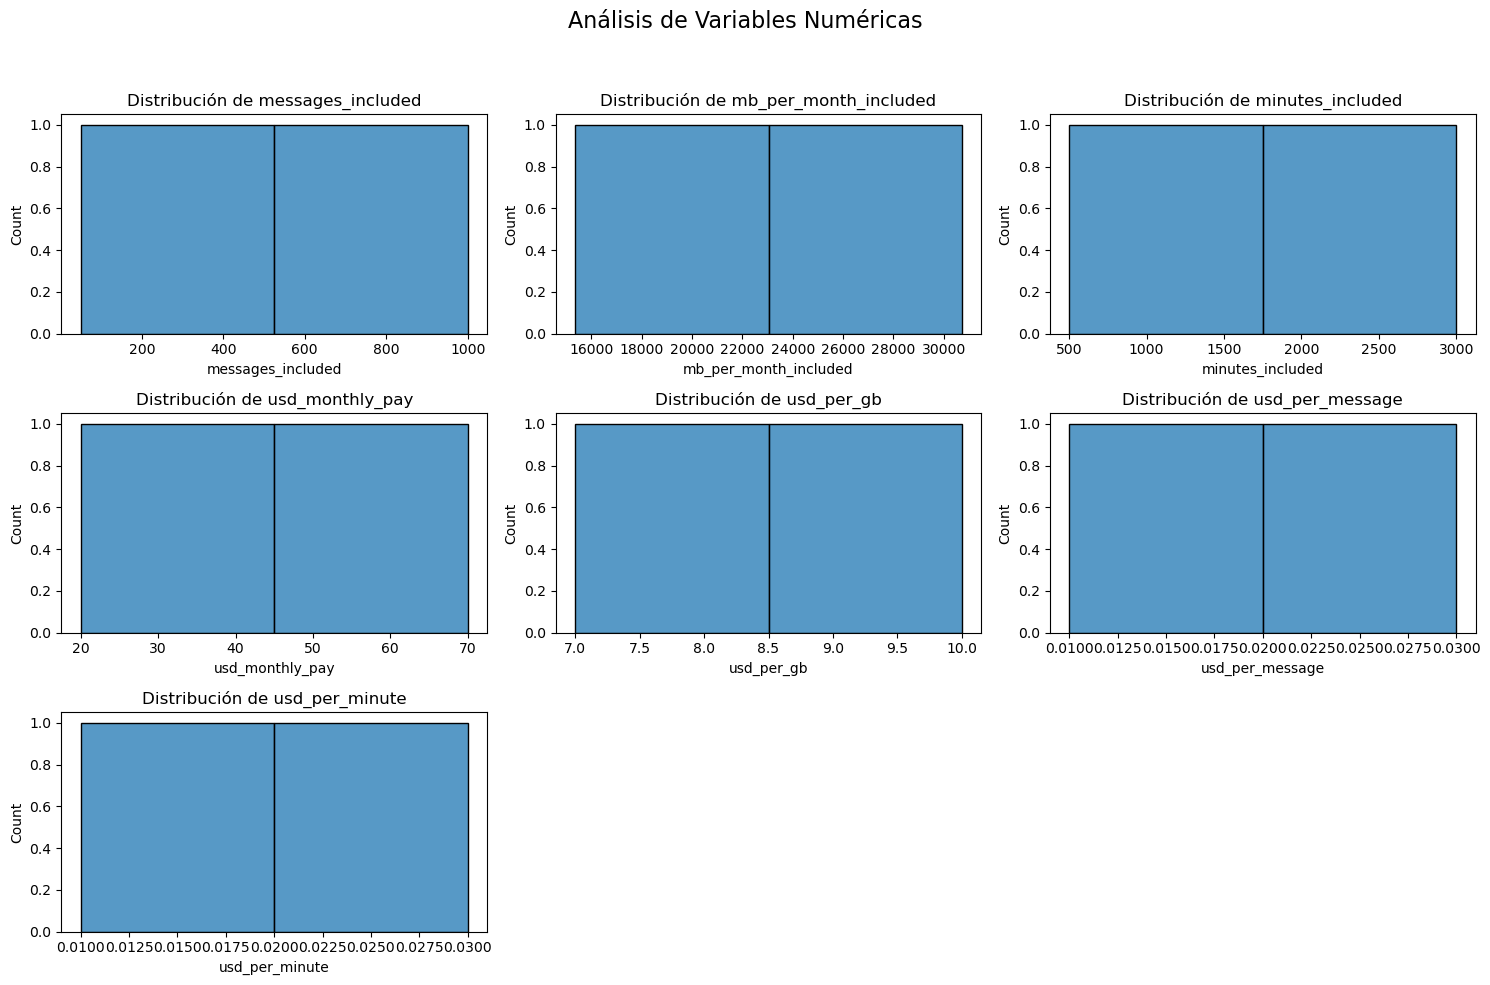

In [19]:

source_file = '../data/raw/megaline_plans.csv'
df_plans = pd.read_csv(source_file, low_memory=False)
analisis_exploratorio('Plans', df_plans)

In [40]:
df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


No hay incosistencias

|                                                 Análisis de la tabla Users                                                |
Dimensiones: (500, 8)

Estadísticas descriptivas y problemas de calidad:
|                               | user_id         | first_name      | last_name       | age                | city            | reg_date        | plan            | churn_date      |
|:------------------------------|:----------------|:----------------|:----------------|:-------------------|:----------------|:----------------|:----------------|:----------------|
| Valores Únicos                | 500             | 458             | 399             | 58                 | 73              | 266             | 2               | 29              |
| Media                         | -               | -               | -               | 45.486             | -               | -               | -               | -               |
| Desviación Estándar           | -               | -               | -      

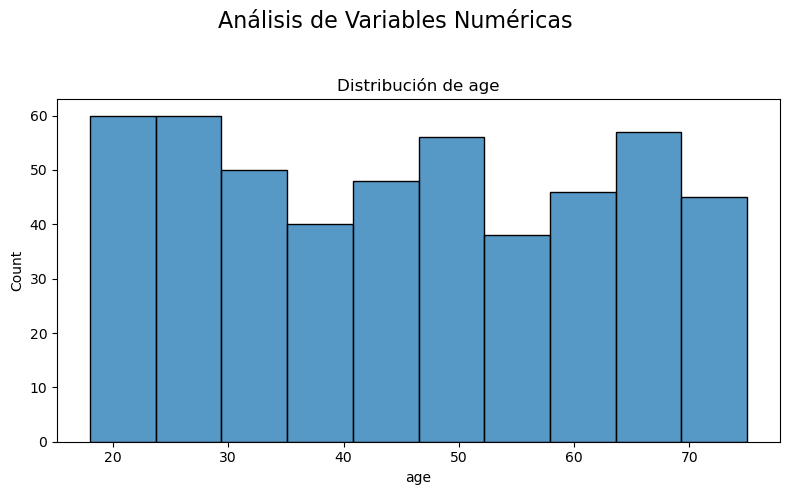

In [39]:
source_file = '../data/raw/megaline_users.csv'
df_users = pd.read_csv(source_file, low_memory=False)
analisis_exploratorio('Users', df_users)

No se encuentran incosistencias en la mayoria de columnas solo en churn date que podrían ser los usuarios que no han abandonado el servicio y por ende no tienen un churn date se los puede imputar con alguna fecha futura

In [42]:
df_users[df_users['churn_date'].isna()]

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,NaN
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,NaN
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,NaN
3,1003,reynaldo,jenkins,52,"tulsa, ok msa",2018-01-28,surf,NaN
4,1004,leonila,thompson,40,"seattle-tacoma-bellevue, wa msa",2018-05-23,surf,NaN
...,...,...,...,...,...,...,...,...
495,1495,fidel,sharpe,67,"new york-newark-jersey city, ny-nj-pa msa",2018-09-04,surf,NaN
496,1496,ariel,shepherd,49,"new orleans-metairie, la msa",2018-02-20,surf,NaN
497,1497,donte,barrera,49,"los angeles-long beach-anaheim, ca msa",2018-12-10,ultimate,NaN
498,1498,scot,williamson,51,"new york-newark-jersey city, ny-nj-pa msa",2018-02-04,surf,NaN
